# Combined Population Health and Service Capacity Model

## Overview

This notebook contains the code to develop and test the combined model.

Further details on the development of the population health model can be found [here](./population_health_model.ipynb), and the service capacity model can be found [here](./capacity_model.ipynb).

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('../data/master_scaled.csv', index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]])
               if '/' in c else c for c in dta.columns]

In [5]:
dta.head()

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives
0,00Q,Jan,406.655830,308.945095,310.561801,234.716187,4568.019766,1179.855246,14.8942,97.2,99.7,94.4
1,00Q,Feb,349.933603,256.872981,261.756435,205.298797,3910.918344,1075.452189,14.8942,97.2,99.7,94.4
2,00Q,Mar,413.247659,300.690725,303.676215,234.716187,4051.778545,1210.874032,14.8942,97.2,99.7,94.4
3,00Q,Apr,349.608595,278.140171,264.973181,203.677924,3974.433001,1186.166427,14.8942,97.2,99.7,94.4
4,00Q,May,361.100544,284.419492,294.361403,227.926437,4232.385761,1299.297713,14.8942,97.2,99.7,94.4


In [6]:
dta.shape

(1425, 12)

## Function to group data 

In [7]:
def group_data(data, features):

    features = ['population',
                'People', 'Places',
                'Lives']


    #ensure no identical points in train and test

    grouped = pd.DataFrame()
    
    for pop, group in data.groupby('population'):

        #if len(group.lives.unique())>1:

            #print('multiple CCG with same population')

        ccg_year = pd.Series(dtype='float64')

        for f in features:

            ccg_year[f] = group[f].unique()[0]

        ccg_year['ae_attendances_attendances']\
        = group.ae_attendances_attendances.mean()
        

        grouped = grouped.append(ccg_year, ignore_index=True)
        
    return grouped

## Fit Predict Population Health model

In [8]:
model = RandomForestRegressor(max_depth=3, n_estimators=2, 
                              random_state=0)

pophealth_features = ['population',
                    'People', 'Places', 'Lives']

grouped = group_data(dta, pophealth_features)

y = grouped['ae_attendances_attendances']

X = grouped[pophealth_features]

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
results = pd.DataFrame()


scores_train, scores_test, feat = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    test = X.iloc[test_index].copy()
    test['ae_predicted'] = model.predict(X.iloc[test_index])
    
    results = results.append(test, ignore_index=True)

In [9]:
results

,population,People,Places,Lives,ae_predicted
0,13.9240,84.800000,98.500000,88.500000,1270.932902
1,14.8942,97.200000,99.700000,94.400000,1051.002273
2,26.5294,97.850000,102.100000,99.500000,472.715590
3,28.5372,95.200000,100.100000,96.600000,472.715590
4,29.1775,100.200000,104.400000,104.200000,381.722990
...,...,...,...,...,...
123,58.6485,94.200000,99.200000,99.000000,385.192306
124,63.3558,106.166667,101.866667,107.616667,332.828873
125,92.7598,101.800000,101.733333,107.750000,332.828873
126,102.1991,103.040000,99.660000,103.696667,385.192306


### Merge with data set 

In [10]:
dta = dta.merge(results[['population','ae_predicted']],\
                left_on='population', right_on='population')

In [11]:
dta

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives,ae_predicted
0,00Q,Jan,406.655830,308.945095,310.561801,234.716187,4568.019766,1179.855246,14.8942,97.2,99.7,94.4,1051.002273
1,00Q,Feb,349.933603,256.872981,261.756435,205.298797,3910.918344,1075.452189,14.8942,97.2,99.7,94.4,1051.002273
2,00Q,Mar,413.247659,300.690725,303.676215,234.716187,4051.778545,1210.874032,14.8942,97.2,99.7,94.4,1051.002273
3,00Q,Apr,349.608595,278.140171,264.973181,203.677924,3974.433001,1186.166427,14.8942,97.2,99.7,94.4,1051.002273
4,00Q,May,361.100544,284.419492,294.361403,227.926437,4232.385761,1299.297713,14.8942,97.2,99.7,94.4,1051.002273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,X2C4Y,Aug,281.008273,253.093792,459.652700,306.843650,3982.517935,390.405530,44.0337,93.3,98.3,97.6,515.867172
1421,X2C4Y,Sep,263.936917,240.868701,453.078703,305.262399,4598.750502,388.679580,44.0337,93.3,98.3,97.6,515.867172
1422,X2C4Y,Oct,286.454848,254.680032,488.348051,327.202669,5225.611293,391.268506,44.0337,93.3,98.3,97.6,515.867172
1423,X2C4Y,Nov,326.984206,276.374619,499.497654,306.953594,4606.948769,389.542555,44.0337,93.3,98.3,97.6,515.867172


## Combined model 

In [12]:
#capacity utility model
rf1 = RandomForestRegressor(max_depth=5, n_estimators=4, 
                            random_state=0)

#combinator
final = LinearRegression()

train, test = train_test_split(dta,random_state=29)

#split training data into two sets
train_0, train_1 = train_test_split(train, train_size=0.75, 
                                    random_state=29)



#capacity utility
capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

pophealth_features = ['population',
                    'People', 'Places', 'Lives']

#train capacity modeel

y_0 = train_0['ae_attendances_attendances']
X_0 = train_0[capacity_features]

rf1.fit(X_0,y_0)


#predict

y_pred_cu = rf1.predict(train_1[capacity_features])

print(rf1.score(train_1[capacity_features], 
                train_1['ae_attendances_attendances']))

y_pred_ph = train_1['ae_predicted']


0.40477370122358636


In [13]:
X_f = np.vstack([y_pred_cu, y_pred_ph]).T
y_f = train_1['ae_attendances_attendances']

final.fit(X_f,y_f)

final.score(X_f,y_f)

0.6223340990025038

### Check performance on held out data 

In [14]:
from sklearn.metrics import r2_score as r2

y_pred_cu = rf1.predict(test[capacity_features])

print(rf1.score(test[capacity_features], 
                test['ae_attendances_attendances']))

#y_pred_ph = rf2.predict(test[pophealth_features])

y_pred_ph = test['ae_predicted']

print(r2(test['ae_attendances_attendances'], test['ae_predicted']))

y_pred_final = final.predict(np.vstack([y_pred_cu, y_pred_ph]).T)

#print(r2_score(test['ae_attendances_attendances'], y_pred_final))

print(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,
                  test['ae_attendances_attendances']))

0.441254188439128
0.5452611564926692
0.6355467401718082


### Coefficients 

In [15]:
final.coef_

array([0.5192824 , 0.62027602])

## Combined model with optimised parameters 

In [16]:
def fit_ph(dta, features, model):
    
    if 'ae_predicted' in dta.columns:
        
        dta = dta.drop(['ae_predicted'], axis=1)
    
    grouped = group_data(dta, features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    # dont set random state so that function can be used in overall cv
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    results = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        test = X.iloc[test_index].copy()
        
        test['ae_predicted'] = model.predict(X.iloc[test_index])
    
        results = results.append(test, ignore_index=True)
        
    dta = dta.merge(results[['population','ae_predicted']],
                    left_on='population', right_on='population')
        
    return dta

In [17]:
def fit_capacity(dta, features, model):
    
    y = dta['ae_attendances_attendances']
    X = dta[features]

    model.fit(X,y)
    
    return model

In [18]:
def fit_combined(train, rf1, m1_features, train_size=7/8):
    
    final = LinearRegression()

    #split training data into two sets
    train_0, train_1 = train_test_split(train, 
                                        train_size=train_size, 
                                        random_state=29)

    #train capactiy model
    
    rf1 = fit_capacity(train_0, m1_features, rf1)
    

    #predict monthly attendances

    y_pred_1 = rf1.predict(train_1[m1_features])

    
    #use pre-predicted average attendances
    
    y_pred_2 = train_1['ae_predicted']
        
    #final
        
    X_f = np.vstack([y_pred_1, y_pred_2]).T
    y_f = train_1['ae_attendances_attendances']

    final.fit(X_f,y_f)
    
    return rf1,final        

In [19]:
def cv_combined(dta, rf1, rf2):
    
    # splitter for cross validation 
    
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    scores_final, scores_rf1, scores_rf2, coefs = [],[],[],[]
    
    k=1
    
    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    dta_pred = pd.DataFrame()
    
    #fit population health independently to avoid data leakage
    
    dta = fit_ph(dta, pophealth_features, rf2)
    
    print(dta.shape)
    
    for train_index, test_index in cv.split(dta):
        
        #print(f'\n Split {k} \n')
        
        train = dta.iloc[train_index]
        test = dta.iloc[test_index]

        #final models
        rf1, final = fit_combined(train, rf1, capacity_features)
        
        coefs.append(final.coef_)
        
        #predict on test data
        
        y_pred_cu = rf1.predict(test[capacity_features])

        scores_rf1.append(rf1.score(test[capacity_features],
                                    test['ae_attendances_attendances']))

        y_pred_ph = test['ae_predicted']

        scores_rf2.append(r2(test['ae_attendances_attendances'],
                             test['ae_predicted']))
        
        preds = final.predict(np.vstack([y_pred_cu, y_pred_ph]).T)

        scores_final.append(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,
                                        test['ae_attendances_attendances']))
        
        test_pred = test.copy()
        test_pred['predicted'] = preds
        test_pred['true'] = test['ae_attendances_attendances'].values
        
        test_pred['iter'] = [k for i in test_pred.index]
        
        dta_pred = dta_pred.append(test_pred, ignore_index=False)
        
        
        k+=1
        
    return scores_final, scores_rf1, scores_rf2, dta_pred, coefs

In [20]:
#capacity model
rf1 = RandomForestRegressor(max_depth=5, n_estimators=4, random_state=0)

#population health model
rf2 = RandomForestRegressor(max_depth=3, n_estimators=2, random_state=0)

scores_final, scores_rf1, scores_rf2, \
dta_pred, coefs = cv_combined(dta, rf1, rf2)

(1425, 13)


In [21]:
results=pd.DataFrame()

results['final'] = scores_final
results['capacity'] = scores_rf1
results['population_health'] = scores_rf2

In [22]:
results.describe()

,final,capacity,population_health
count,25.000000,25.000000,25.000000
mean,0.652897,0.397873,0.581512
std,0.042571,0.051272,0.050794
min,0.561164,0.287035,0.460972
25%,0.618940,0.361814,0.552561
50%,0.662421,0.401308,0.590778
75%,0.685946,0.431872,0.619018
max,0.712853,0.489252,0.659609


### Plot 

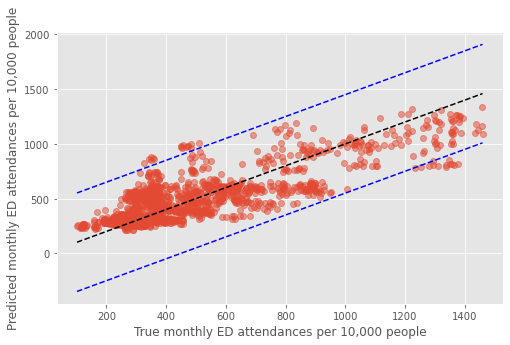

In [23]:
fig,ax = plt.subplots(figsize=(8,5))

mean_pred, true = [],[]

for i in dta_pred.index.unique():
    
    mean_pred.append(dta_pred.loc[i]['predicted'].mean())
    true.append(dta_pred.loc[i]['true'].mean())

plt.plot(true, mean_pred, 'o', alpha=0.5)

xx = np.arange(min(dta_pred['true']),max(dta_pred['true']))
plt.plot(xx,xx,'k--')
plt.plot(xx, xx-450, 'b--')
plt.plot(xx, xx+450, 'b--')

plt.xlabel('True monthly ED attendances per 10,000 people')
plt.ylabel('Predicted monthly ED attendances per 10,000 people')
plt.savefig('true_predicted_combined.png')
plt.show()

## Permutation Feature Importance 

In [24]:
def fit_ph_shuffle(dta, features,f, model):
    
    if 'ae_predicted' in dta.columns:
        
        dta = dta.drop(['ae_predicted'], axis=1)
    
    grouped = group_data(dta, features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[features]
    
    X_shuffled = X.copy()
    
    X_shuffled[f] = np.random.permutation(X[f].values)
    
    
    # dont set random state so that function can be used in overall cv
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    results = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        test = X.iloc[test_index].copy()
        
        test['ae_predicted'] = model.predict(X_shuffled.iloc[test_index])
    
        results = results.append(test, ignore_index=True)
        
    dta = dta.merge(results[['population','ae_predicted']],
                    left_on='population', right_on='population')
        
    return dta

In [25]:
def permeate_feature(dta, f,rf1, rf2):
    
    
    shuffled = dta.copy()

    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    if f in capacity_features:
    
        shuffled[f] = np.random.permutation(dta[f].values)
    
    else:
        
        shuffled = fit_ph_shuffle(shuffled, pophealth_features,f, rf2)
        
    
    dta = fit_ph(dta, pophealth_features, rf2)
    
    # splitter for cross validation
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    #importances = pd.DataFrame()
    
    shuffled_score, true_score  = [],[]
    
    #print(f'running for {f} \n')
    
    for train_index, test_index in cv.split(dta):
        
        test_shuffled = shuffled.iloc[test_index]
        
        train = dta.iloc[train_index]
        test = dta.iloc[test_index]
        
        
        #final models
        rf1, final = fit_combined(train, rf1, capacity_features)

        
        
        #predict on test data
        
        y_pred_cu = rf1.predict(test[capacity_features])

        y_pred_ph = test['ae_predicted']
        
        y_pred_cus = rf1.predict(test_shuffled[capacity_features])
        
        if f in capacity_features:

            y_pred_phs = test['ae_predicted']
            
        else:
            
            y_pred_phs = test_shuffled['ae_predicted']
            
        
        true_score.append(
            final.score(np.vstack([y_pred_cu, y_pred_ph]).T,\
                                                test['ae_attendances_attendances']))
        
        shuffled_score.append(
            true_score[-1] - final.score(np.vstack([y_pred_cus, y_pred_phs]).T,\
                                            test['ae_attendances_attendances']))
        
    #print(f'{f} complete\n')
    
    return true_score, shuffled_score       

In [26]:
def feature_importance_combined(dta, rf1, rf2):
    
    importances = pd.DataFrame()
    
    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
    #            '111_111_answered', 'amb_sys_made']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    
    for f in capacity_features + pophealth_features:
        
        
        true_score, shuffled_score = permeate_feature(dta, f,rf1, rf2)
        
        if 'score' in importances.columns:
        
            importances['score'] = np.mean([importances['score'].values, true_score],axis=0)
            
        else:
            
            importances['score'] = true_score
            
        importances[f] = shuffled_score
  

    return importances

In [27]:
#set random seed to make results reproducible
numpy.random.seed(0)

importances = feature_importance_combined(dta, rf1, rf2)

NameError: name 'numpy' is not defined

In [28]:
importances.describe()

,score,gp_appt_available,111_111_offered,amb_sys_answered,population,People,Places,Lives
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.652897,0.027086,0.066191,0.144325,0.451598,0.037677,0.029621,0.101341
std,0.042571,0.018281,0.018686,0.044304,0.065514,0.011443,0.011564,0.039950
min,0.561164,0.002236,0.033869,0.074645,0.283854,0.021200,0.004587,0.017951
25%,0.618940,0.016875,0.056239,0.110030,0.425416,0.028212,0.020026,0.068663
50%,0.662421,0.021924,0.064825,0.138735,0.465319,0.038463,0.028411,0.101402
75%,0.685946,0.033144,0.078997,0.173100,0.493657,0.045088,0.039828,0.132218
max,0.712853,0.071461,0.110090,0.231839,0.563205,0.065389,0.048126,0.188220


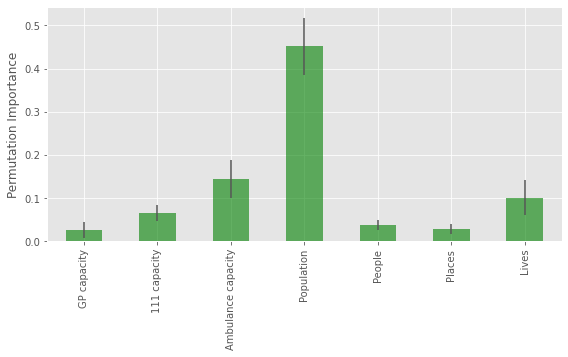

In [29]:
fig,ax = plt.subplots(figsize=(8,5))

importances[importances.columns[1:]].describe().loc['mean'].plot(kind='bar', \
            yerr = importances[importances.columns[1:]].describe().loc['std'],\
                            alpha=0.6, color='g',ax=ax)

plt.ylabel('Permutation Importance', fontsize=12)
plt.tight_layout()

tick_labels = ['GP capacity','111 capacity', 'Ambulance capacity',\
               'Population', 'People', 'Places', 'Lives']

ax.set_xticklabels(tick_labels)

plt.savefig('importance.png')
plt.show()

## Train final model on all data and save for forecasting 

In [30]:
def fit_final(dta, rf1, rf2, m1_features, m2_features):
    
    
    final = LinearRegression()


    #train capactiy model
    
    rf1 = fit_capacity(dta, m1_features, rf1)
    

    #predict monthly attendances

    y_pred_1 = rf1.predict(dta[m1_features])

    
    
    grouped = group_data(dta, m2_features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[m2_features]

    rf2.fit(X, y)
    
    y_pred_2 = rf2.predict(dta[m2_features])
        
        
    X_f = np.vstack([y_pred_1, y_pred_2]).T
    y_f = dta['ae_attendances_attendances']

    final.fit(X_f,y_f)

    print('Combined training score:',final.score(X_f,y_f))
    
    return rf1,rf2, final        

In [31]:
m1_features = capacity_features
m2_features = pophealth_features

rf1,rf2,final = fit_final(dta, rf1, rf2, m1_features, m2_features)

Combined training score: 0.8014005341273812


In [32]:
with open('stacked_model_scaled.pkl','wb') as f:
    
    pkl.dump([[rf1,rf2,final], m1_features, m2_features], f)